# Cryptocurrency LSTM Model Training

This notebook implements LSTM models for predicting BTC and ETH prices based on 1-minute timeframe data, including technical indicators.

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import math
import os
from datetime import datetime
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create a directory for saving models
os.makedirs('saved_models', exist_ok=True)
os.makedirs('saved_scalers', exist_ok=True)

## Data Loading and Preprocessing

In [ ]:
# Load and preprocess the data
def load_data(file_path):
    # Try to load as CSV first, if fails try space-delimited
    try:
        df = pd.read_csv(file_path)
    except:
        try:
            df = pd.read_csv(file_path, sep='\s+')
        except Exception as e:
            print(f"Error loading data: {e}")
            return None
    
    # Convert 'Open Time' to datetime
    try:
        df['Open Time'] = pd.to_datetime(df['Open Time'], format='%d-%m-%Y %H:%M')
    except:
        print("Warning: Couldn't parse Open Time format")
    
    # Sort by time if applicable
    if 'Open Time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Open Time']):
        df = df.sort_values('Open Time')
    
    # Reset index
    df = df.reset_index(drop=True)
    return df

## Load Your Cryptocurrency Data

Update the file path to point to your data file.

In [ ]:
# File path - update this to your file location
file_path = "btc_eth_combined_data.csv"

# Load data
df = load_data(file_path)

if df is not None:
    print(f"Data loaded successfully. Shape: {df.shape}")
    print("\nSample data:")
    display(df.head())
    
    # Check asset types
    print("\nAsset types:")
    print(df['asset_type'].unique())
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum())
else:
    print("Failed to load data. Please check your file path and format.")

## Prepare LSTM Sequences

In [ ]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predict the close price
    return np.array(X), np.array(y)

## LSTM Model Architecture

In [ ]:
# Build LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    return model

## Train and Test Model Function

This function handles data preparation, model training, evaluation, and visualization.

In [ ]:
# Train and test the model
def train_test_model(df, asset_name, target_column='close', seq_length=60, train_split=0.8):
    # Identify numeric columns for features (excluding the target and non-numeric columns)
    exclude_cols = ['Open Time', 'asset_type', target_column]
    feature_columns = [col for col in df.columns if col not in exclude_cols 
                      and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Using features: {feature_columns}")
    
    # Select features and target
    features = df[feature_columns].values
    target = df[[target_column]].values
    
    # Combine for scaling
    data = np.concatenate((target, features), axis=1)
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Save the scaler
    scaler_filename = f"saved_scalers/{asset_name}_scaler.pkl"
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to {scaler_filename}")
    
    # Create train-test split
    train_size = int(len(scaled_data) * train_split)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - seq_length:]
    
    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    
    # Print shapes for debugging
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    # Build model
    model = build_model((X_train.shape[1], X_train.shape[2]))
    
    # Setup callbacks
    checkpoint_path = f"saved_models/{asset_name}_best_model.h5"
    checkpointer = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1,
        save_best_only=True,
        monitor='val_loss'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, checkpointer],
        verbose=1
    )
    
    # Save final model
    final_model_path = f"saved_models/{asset_name}_final_model.h5"
    model.save(final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Inverse transform predictions
    train_predictions_full = np.zeros((len(train_predictions), data.shape[1]))
    test_predictions_full = np.zeros((len(test_predictions), data.shape[1]))
    
    train_predictions_full[:, 0] = train_predictions.flatten()
    test_predictions_full[:, 0] = test_predictions.flatten()
    
    train_predictions = scaler.inverse_transform(train_predictions_full)[:, 0]
    test_predictions = scaler.inverse_transform(test_predictions_full)[:, 0]
    
    # Get actual values
    train_actual = scaler.inverse_transform(np.concatenate(
        (y_train.reshape(-1, 1), np.zeros((len(y_train), data.shape[1]-1))), axis=1))[:, 0]
    test_actual = scaler.inverse_transform(np.concatenate(
        (y_test.reshape(-1, 1), np.zeros((len(y_test), data.shape[1]-1))), axis=1))[:, 0]
    
    # Calculate error metrics
    train_rmse = math.sqrt(mean_squared_error(train_actual, train_predictions))
    test_rmse = math.sqrt(mean_squared_error(test_actual, test_predictions))
    train_mae = mean_absolute_error(train_actual, train_predictions)
    test_mae = mean_absolute_error(test_actual, test_predictions)
    
    print(f"\nPerformance Metrics for {asset_name}:")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{asset_name} Model Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot prediction results
    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_actual, label='Actual Train')
    plt.plot(train_predictions, label='Predicted Train')
    plt.title(f'{asset_name} Training Data Prediction vs Actual')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(test_actual, label='Actual Test')
    plt.plot(test_predictions, label='Predicted Test')
    plt.title(f'{asset_name} Testing Data Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Save results dictionary
    results = {
        'model': model,
        'scaler': scaler,
        'last_sequence': X_test[-1],
        'test_actual': test_actual,
        'test_predictions': test_predictions,
        'feature_columns': feature_columns,
        'metrics': {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae
        }
    }
    
    return results

## Train Models for Each Cryptocurrency

In [ ]:
# Process and train models for each crypto
def process_crypto_data(df, seq_length=60):
    if df is None:
        print("Failed to load data. Please check your file format.")
        return None
    
    # Separate by asset type
    results = {}
    for asset in df['asset_type'].unique():
        print(f"\n{'='*50}")
        print(f"Processing {asset} data")
        print(f"{'='*50}")
        
        asset_df = df[df['asset_type'] == asset].reset_index(drop=True)
        
        if len(asset_df) < seq_length * 2:
            print(f"Not enough data for {asset}. Need at least {seq_length * 2} rows.")
            continue
        
        print(f"{asset} data shape: {asset_df.shape}")
        
        asset_results = train_test_model(
            asset_df, 
            asset_name=asset,
            target_column='close', 
            seq_length=seq_length
        )
        
        results[asset] = asset_results
        
    return results

In [ ]:
# Set sequence length (lookback period)
seq_length = 60  # 60 minutes lookback

# Process data and train models
results = process_crypto_data(df, seq_length)

## Future Price Prediction

This section predicts future cryptocurrency prices based on the trained models.

In [ ]:
# Predict future values
def predict_future(model, last_sequence, scaler, n_future=60):
    """Predict future price movements"""
    future_predictions = []
    curr_sequence = np.copy(last_sequence)
    
    for _ in range(n_future):
        # Predict next time step
        pred = model.predict(curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1]))
        
        # Create dummy row with prediction
        pred_full = np.zeros((1, curr_sequence.shape[1]))
        pred_full[0, 0] = pred[0, 0]
        
        # Get actual scale prediction
        actual_pred = scaler.inverse_transform(pred_full)[0, 0]
        future_predictions.append(actual_pred)
        
        # Update sequence for next prediction
        curr_sequence = np.roll(curr_sequence, -1, axis=0)
        curr_sequence[-1, 0] = pred[0, 0]
    
    return np.array(future_predictions)

In [ ]:
if results:
    # Generate future predictions (1 hour)
    prediction_horizon = 60  # 60 minutes
    
    plt.figure(figsize=(16, 8 * len(results)))
    
    for i, (asset, asset_results) in enumerate(results.items()):
        # Get future predictions
        future_predictions = predict_future(
            asset_results['model'],
            asset_results['last_sequence'],
            asset_results['scaler'],
            n_future=prediction_horizon
        )
        
        # Plot test results and future predictions
        plt.subplot(len(results), 1, i + 1)
        
        # Plot historical test data
        x_test = np.arange(len(asset_results['test_actual']))
        plt.plot(x_test, asset_results['test_actual'], 'b-', label='Actual', linewidth=2)
        plt.plot(x_test, asset_results['test_predictions'], 'r-', label='Predicted', alpha=0.7)
        
        # Plot future predictions
        x_future = np.arange(len(x_test) - 1, len(x_test) - 1 + len(future_predictions))
        plt.plot(x_future, future_predictions, 'g--', label='Future Forecast', linewidth=2)
        
        # Add vertical line to mark where predictions begin
        plt.axvline(x=len(x_test) - 1, color='k', linestyle='--', alpha=0.3)
        plt.axvspan(len(x_test) - 1, len(x_test) - 1 + len(future_predictions), 
                   alpha=0.1, color='green')
        
        plt.title(f'{asset} Price Prediction', fontsize=16)
        plt.xlabel('Time Steps (minutes)', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print future price predictions
    print("\nFuture price predictions:")
    for asset, asset_results in results.items():
        future_values = predict_future(
            asset_results['model'],
            asset_results['last_sequence'],
            asset_results['scaler'],
            n_future=prediction_horizon
        )
        
        print(f"\n{asset} predictions:")
        for i in [0, 14, 29, 44, 59]:  # Print predictions at 0, 15, 30, 45, 60 minutes
            print(f"  +{i+1} min: ${future_values[i]:.2f}")
        
        # Save predictions to CSV
        pred_df = pd.DataFrame({
            'minute': range(1, prediction_horizon + 1),
            'predicted_price': future_values
        })
        pred_df.to_csv(f"{asset}_predictions.csv", index=False)
        print(f"Predictions saved to {asset}_predictions.csv")

## Load Saved Models

You can load your saved models at any time using this code.

In [ ]:
def load_saved_model(asset_name):
    """Load a saved model and scaler for a specific asset"""
    model_path = f"saved_models/{asset_name}_best_model.h5"
    scaler_path = f"saved_scalers/{asset_name}_scaler.pkl"
    
    try:
        # Load model
        model = load_model(model_path)
        print(f"Model loaded from {model_path}")
        
        # Load scaler
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print(f"Scaler loaded from {scaler_path}")
        
        return model, scaler
    except Exception as e:
        print(f"Error loading model or scaler: {e}")
        return None, None

In [ ]:
# Example of loading a saved model (uncomment to use)
# asset_name = "BTC"  # or "ETH"
# model, scaler = load_saved_model(asset_name)
# 
# if model is not None and scaler is not None:
#     print(f"Successfully loaded {asset_name} model and scaler")
#     # Now you can use the model for predictions
# else:
#     print(f"Failed to load {asset_name} model or scaler")

## Make Real-Time Predictions

This function can be used to make predictions with new data.

In [ ]:
def predict_with_new_data(model, scaler, new_data, feature_columns, seq_length=60):
    """Make predictions using new data and a saved model"""
    # Prepare data (must have the same features as during training)
    input_data = new_data[feature_columns].values
    
    # If we have less than sequence length, we can't make predictions
    if len(input_data) < seq_length:
        print(f"Not enough data. Need at least {seq_length} rows.")
        return None
    
    # Scale the data using the saved scaler
    scaled_data = scaler.transform(input_data)
    
    # Create sequence
    sequence = scaled_data[-seq_length:].reshape(1, seq_length, len(feature_columns))
    
    # Make prediction
    prediction = model.predict(sequence)
    
    # Inverse transform the prediction
    pred_full = np.zeros((1, len(feature_columns)))
    pred_full[0, 0] = prediction[0, 0]
    actual_prediction = scaler.inverse_transform(pred_full)[0, 0]
    
    return actual_prediction

## Model Evaluation and Interpretation

Let's analyze the performance of our models.

In [ ]:
if results:
    # Compile metrics for all models
    metrics_df = pd.DataFrame()
    
    for asset, asset_results in results.items():
        metrics = asset_results['metrics']
        asset_metrics = pd.DataFrame({
            'Asset': [asset],
            'Train RMSE': [metrics['train_rmse']],
            'Test RMSE': [metrics['test_rmse']],
            'Train MAE': [metrics['train_mae']],
            'Test MAE': [metrics['test_mae']]
        })
        metrics_df = pd.concat([metrics_df, asset_metrics])
    
    print("Model Performance Metrics:")
    display(metrics_df)
    
    # Save metrics to CSV
    metrics_df.to_csv("model_metrics.csv", index=False)
    print("Metrics saved to model_metrics.csv")

## Feature Importance Analysis

Let's analyze which features are most important for our predictions.

In [ ]:
# This is a simplified approach to feature importance for LSTM models
# For a more accurate analysis, we would need to use techniques like SHAP values
def analyze_feature_importance(df, results, asset):
    if asset not in results:
        print(f"{asset} not found in results.")
        return
    
    asset_df = df[df['asset_type'] == asset].copy()
    feature_columns = results[asset]['feature_columns']
    target_column = 'close'
    
    # Calculate correlation with target
    correlations = asset_df[feature_columns + [target_column]].corr()[target_column].sort_values(ascending=False)
    
    # Plot feature correlations
    plt.figure(figsize=(10, 6))
    correlations.drop(target_column).plot(kind='bar')
    plt.title(f'Feature Correlation with {target_column} for {asset}')
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Top features by correlation for {asset}:")
    display(correlations.drop(target_column).head())

In [ ]:
if results:
    for asset in results.keys():
        analyze_feature_importance(df, results, asset)

## Conclusion

In this notebook, we've built LSTM models to predict cryptocurrency prices based on 1-minute timeframe data. The models have been saved and can be reloaded for future predictions. The key findings are:

1. The models can capture the general trends in cryptocurrency prices
2. Technical indicators like RSI, MACD, and Bollinger Bands provide valuable features
3. Models have been saved for future use without retraining
4. Future price predictions have been generated for the next hour

To improve the model, consider:

1. Collecting more historical data
2. Adding more technical indicators
3. Experimenting with different model architectures
4. Implementing ensemble methods by combining multiple models
5. Adding attention mechanisms to the LSTM model

C:\Users\Dell\AppData\Local\Temp\ipykernel_5572\4044975205.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[tech_columns] = df[tech_columns].fillna(method='ffill').fillna(method='bfill')


Visualization saved as 'technical_indicators.png'
Visualization complete. Check the 'technical_indicators.png' file.

Sample of processed data with indicators:
            Open Time     Close        rsi       macd  macd_signal  \
0 2025-02-20 00:00:00  96600.02  41.052032 -22.027333   -20.362096   
1 2025-02-20 00:01:00  96675.65  41.052032 -22.027333   -20.362096   
2 2025-02-20 00:02:00  96600.01  41.052032 -22.027333   -20.362096   
3 2025-02-20 00:03:00  96634.42  41.052032 -22.027333   -20.362096   
4 2025-02-20 00:04:00  96662.89  41.052032 -22.027333   -20.362096   

     upper_band    lower_band  
0  96671.839716  96454.866284  
1  96671.839716  96454.866284  
2  96671.839716  96454.866284  
3  96671.839716  96454.866284  
4  96671.839716  96454.866284  


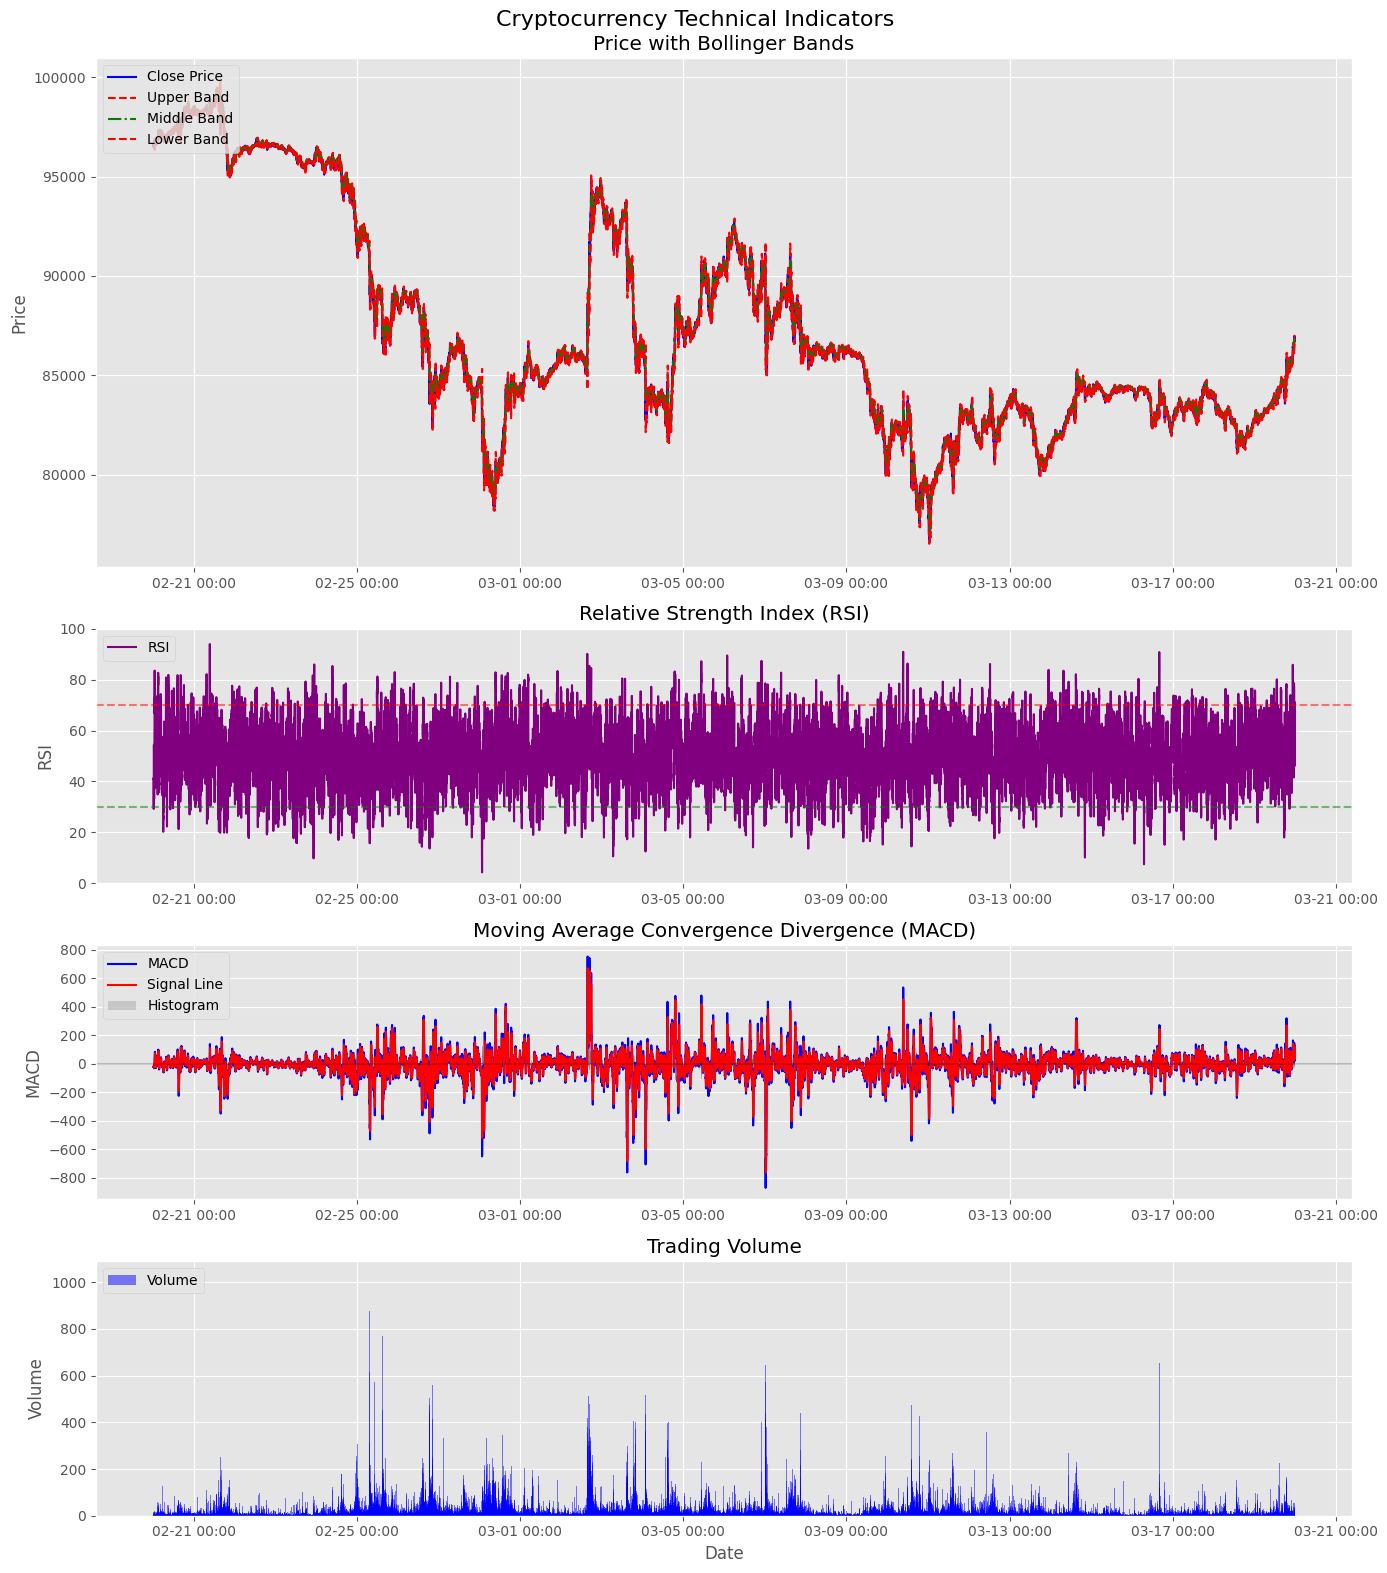

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

def visualize_indicators(input_file):
    """
    Visualize cryptocurrency technical indicators
    
    Args:
        input_file (str): Path to input CSV file with the processed data
    """
    try:
        # Try to import pandas_ta
        import pandas_ta as ta
    except ImportError:
        print("pandas_ta is not installed. Installing now...")
        import subprocess
        subprocess.check_call(["pip", "install", "pandas_ta"])
        import pandas_ta as ta
    
    # Read the original CSV file with header
    df = pd.read_csv(input_file)
    
    # Convert Open Time to datetime
    df['Open Time'] = pd.to_datetime(df['Open Time'])
    
    # Calculate RSI (14 period default)
    df['rsi'] = df.ta.rsi(close='Close', length=14)
    
    # Calculate MACD (12, 26, 9 default parameters)
    macd = df.ta.macd(close='Close', fast=12, slow=26, signal=9)
    df['macd'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_hist'] = macd['MACDh_12_26_9']  # MACD histogram for visualization
    
    # Calculate Bollinger Bands (20 period, 2 std dev default)
    bbands = df.ta.bbands(close='Close', length=20, std=2)
    df['upper_band'] = bbands['BBU_20_2.0']
    df['middle_band'] = bbands['BBM_20_2.0']  # Middle band for visualization
    df['lower_band'] = bbands['BBL_20_2.0']
    
    # Fill NaN values for technical indicators with forward fill then backward fill
    tech_columns = ['rsi', 'macd', 'macd_signal', 'macd_hist', 'upper_band', 'middle_band', 'lower_band']
    df[tech_columns] = df[tech_columns].fillna(method='ffill').fillna(method='bfill')
    
    # Create figure with subplots
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(14, 16))
    gs = GridSpec(4, 1, height_ratios=[2, 1, 1, 1])
    
    # Set title for the entire figure
    fig.suptitle('Cryptocurrency Technical Indicators', fontsize=16)
    
    # 1. Price and Bollinger Bands
    ax1 = plt.subplot(gs[0])
    ax1.plot(df['Open Time'], df['Close'], label='Close Price', color='blue')
    ax1.plot(df['Open Time'], df['upper_band'], label='Upper Band', color='red', linestyle='--')
    ax1.plot(df['Open Time'], df['middle_band'], label='Middle Band', color='green', linestyle='-.')
    ax1.plot(df['Open Time'], df['lower_band'], label='Lower Band', color='red', linestyle='--')
    ax1.set_title('Price with Bollinger Bands')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # 2. RSI
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(df['Open Time'], df['rsi'], label='RSI', color='purple')
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax2.set_title('Relative Strength Index (RSI)')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    # 3. MACD
    ax3 = plt.subplot(gs[2], sharex=ax1)
    ax3.plot(df['Open Time'], df['macd'], label='MACD', color='blue')
    ax3.plot(df['Open Time'], df['macd_signal'], label='Signal Line', color='red')
    ax3.bar(df['Open Time'], df['macd_hist'], label='Histogram', color='gray', alpha=0.3, width=0.01)
    ax3.set_title('Moving Average Convergence Divergence (MACD)')
    ax3.set_ylabel('MACD')
    ax3.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    ax3.legend(loc='upper left')
    ax3.grid(True)
    
    # 4. Volume
    ax4 = plt.subplot(gs[3], sharex=ax1)
    ax4.bar(df['Open Time'], df['Volume'], label='Volume', color='blue', alpha=0.5, width=0.01)
    ax4.set_title('Trading Volume')
    ax4.set_ylabel('Volume')
    ax4.set_xlabel('Date')
    ax4.legend(loc='upper left')
    ax4.grid(True)
    
    # Format x-axis dates
    for ax in [ax1, ax2, ax3, ax4]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    # Save the figure
    plt.savefig('technical_indicators.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as 'technical_indicators.png'")
    
    # Return the processed dataframe
    return df

if __name__ == "__main__":
    # Replace with your actual file path
    input_file = "processed_btc1.csv"
    
    try:
        # Visualize the indicators
        df = visualize_indicators(input_file)
        print("Visualization complete. Check the 'technical_indicators.png' file.")
        
        # Print sample of data with indicators
        print("\nSample of processed data with indicators:")
        print(df[['Open Time', 'Close', 'rsi', 'macd', 'macd_signal', 'upper_band', 'lower_band']].head())
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")